<a href="https://colab.research.google.com/github/Alexandre77777/data_mining/blob/main/8.%20%D0%90%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B5%D0%B2%D1%8B%D0%B5%20%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B%20%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE%20%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0%20%E2%84%9611.%20%D0%90%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B5%D0%B2%D1%8B%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучить модели машинного обучения для решения задачи классификации, используя следующие boosting-алгоритмы: CatBoost, Light GBM, XGBoost, AdaBoost. Сравнить их точность и быстродействие.

Датасет: https://www.kaggle.com/c/titanic/data

In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import time
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [127]:
titanic_data = pd.read_csv('train.csv')

columns_with_missing_values = titanic_data.columns[titanic_data.isnull().any()].tolist()
print("Колонки с пропущенными значениями:")
print(columns_with_missing_values)

Колонки с пропущенными значениями:
['Age', 'Cabin', 'Embarked']


In [128]:
encoded_sex = pd.get_dummies(titanic_data['Sex'], prefix='Sex', drop_first=True)  
titanic_data = pd.concat([titanic_data, encoded_sex], axis=1)
titanic_data.drop(['Sex'], axis=1, inplace=True)

In [129]:
titanic_data.drop(['Cabin', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)
titanic_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male
0,1,0,3,22.0,1,0,7.2500,True
1,2,1,1,38.0,1,0,71.2833,False
2,3,1,3,26.0,0,0,7.9250,False
3,4,1,1,35.0,1,0,53.1000,False
4,5,0,3,35.0,0,0,8.0500,True
...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,True
887,888,1,1,19.0,0,0,30.0000,False
888,889,0,3,NaN,1,2,23.4500,False
889,890,1,1,26.0,0,0,30.0000,True


In [130]:
mean_age = titanic_data['Age'].mean()
std_age = titanic_data['Age'].std()
null_age_count = titanic_data['Age'].isnull().sum()

# Генерация случайных чисел в пределах среднего значения и стандартного отклонения
random_ages = np.random.randint(mean_age - std_age, mean_age + std_age, size=null_age_count)
# Замена NaN в 'Age' на сгенерированные случайные значения
titanic_data.loc[np.isnan(titanic_data['Age']), 'Age'] = random_ages

In [131]:
# Разделение на признаки и целевую переменную для обучающей выборки
X = titanic_data.drop('Survived', axis=1)
y = titanic_data['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [132]:
X_train

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male
331,332,1,45.5,0,0,28.5000,True
733,734,2,23.0,0,0,13.0000,True
382,383,3,32.0,0,0,7.9250,True
704,705,3,26.0,1,0,7.8542,True
813,814,3,6.0,4,2,31.2750,False
...,...,...,...,...,...,...,...
106,107,3,21.0,0,0,7.6500,False
270,271,1,29.0,0,0,31.0000,True
860,861,3,41.0,2,0,14.1083,True
435,436,1,14.0,1,2,120.0000,False


# Обучение моделей

In [135]:
# Инициализация и обучение моделей
models = {
    "CatBoost": CatBoostClassifier(),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

In [136]:
results = {}
for name, model in models.items():
    start_time = time.time()  # Начало отсчета времени обучения
    model.fit(X_train, y_train)
    train_time = time.time() - start_time  # Время обучения

    start_time = time.time()  # Начало отсчета времени предсказания
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time  # Время предсказания

    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        "Accuracy": accuracy,
        "Confusion Matrix": confusion,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Training Time": train_time,
        "Prediction Time": predict_time
    }

# Вывод результатов
for name, metrics in results.items():
    print(f"Модель: {name}")
    print(f"Точность: {metrics['Accuracy']}")
    print(f"Матрица ошибок: \n{metrics['Confusion Matrix']}")
    print(f"Точность (Precision): {metrics['Precision']}")
    print(f"Полнота (Recall): {metrics['Recall']}")
    print(f"F1-мера: {metrics['F1-score']}")
    print(f"Время обучения: {metrics['Training Time']} секунд")
    print(f"Время предсказания: {metrics['Prediction Time']} секунд")
    print("---------------------")

Learning rate set to 0.008911
0:	learn: 0.6872460	total: 1.19ms	remaining: 1.19s
1:	learn: 0.6838762	total: 1.67ms	remaining: 832ms
2:	learn: 0.6786435	total: 2.62ms	remaining: 871ms
3:	learn: 0.6732840	total: 3.29ms	remaining: 819ms
4:	learn: 0.6674458	total: 4.2ms	remaining: 835ms
5:	learn: 0.6621594	total: 5.1ms	remaining: 845ms
6:	learn: 0.6562741	total: 6.02ms	remaining: 855ms
7:	learn: 0.6509633	total: 6.94ms	remaining: 860ms
8:	learn: 0.6455281	total: 7.86ms	remaining: 865ms
9:	learn: 0.6427174	total: 8.35ms	remaining: 827ms
10:	learn: 0.6381112	total: 9.25ms	remaining: 832ms
11:	learn: 0.6353834	total: 9.8ms	remaining: 807ms
12:	learn: 0.6307340	total: 10.6ms	remaining: 801ms
13:	learn: 0.6272728	total: 11.3ms	remaining: 796ms
14:	learn: 0.6222007	total: 12.3ms	remaining: 806ms
15:	learn: 0.6172307	total: 13.3ms	remaining: 818ms
16:	learn: 0.6132433	total: 14.1ms	remaining: 813ms
17:	learn: 0.6084532	total: 14.9ms	remaining: 815ms
18:	learn: 0.6033896	total: 15.8ms	remaining: 8

# Сравнение результатов

In [174]:
import plotly.express as px

model_names = list(results.keys())
training_times = [result["Training Time"] for result in results.values()]

fig_training = px.bar(x=model_names, y=training_times, labels={"x": "Модель", "y": "Время обучения (сек)"},
                      title="Время обучения для каждой модели")
fig_training.update_traces(marker=dict(color=['red' if t == min(training_times) else 'blue' for t in training_times]))

fig_training.show()

prediction_times = [result["Prediction Time"] for result in results.values()]

fig_prediction = px.bar(x=model_names, y=prediction_times, labels={"x": "Модель", "y": "Время предсказания (сек)"},
                        title="Время предсказания для каждой модели")
fig_prediction.update_traces(marker=dict(color=['red' if t == min(prediction_times) else 'blue' for t in prediction_times]))

fig_prediction.show()



# Рассматривая точность

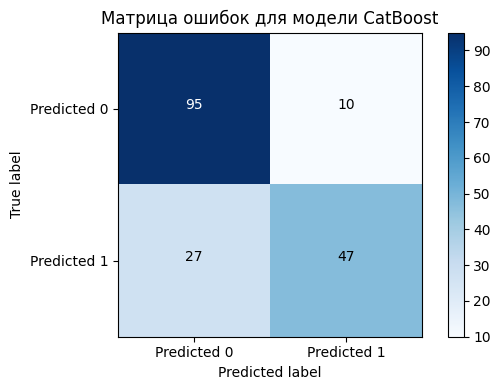

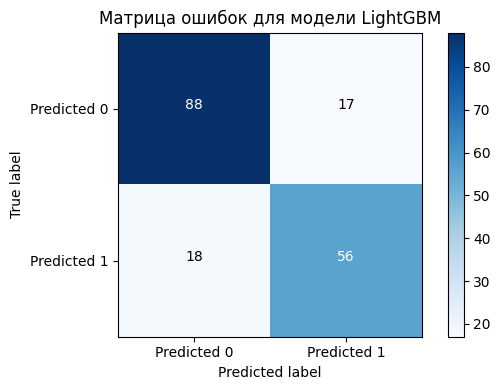

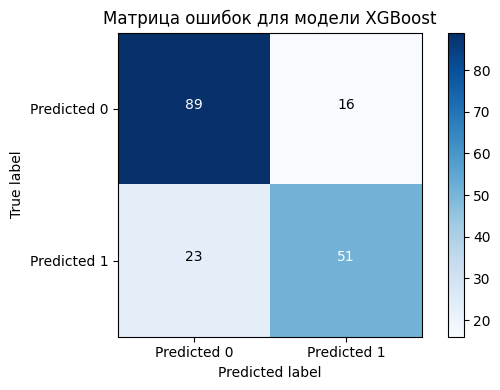

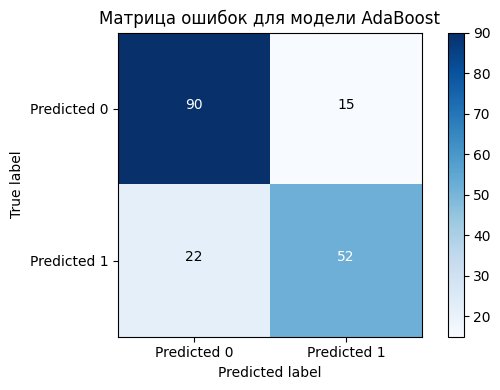

In [166]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(results.keys())
confusion_matrices = [result["Confusion Matrix"] for result in results.values()]

for i, matrix in enumerate(confusion_matrices):
    matrix[[0, 1]] = matrix[[1, 0]]
    matrix[:, [0, 1]] = matrix[:, [1, 0]]

    plt.figure(figsize=(6, 4))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Матрица ошибок для модели {model_names[i]}')
    plt.colorbar()

    classes = ['Predicted 0', 'Predicted 1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = matrix.max() / 2.
    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            plt.text(y, x, format(matrix[x, y], fmt),
                     horizontalalignment="center",
                     color="white" if matrix[x, y] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Анализируя матрицу ошибок

In [173]:
import plotly.express as px

precision_values = [result["Precision"] for result in results.values()] #  tp / (tp + fp)
recall_values = [result["Recall"] for result in results.values()] #  tp / (tp + fn)
f1_values = [result["F1-score"] for result in results.values()] # 2 * (precision * recall) / (precision + recall)


best_precision_idx = precision_values.index(max(precision_values))
best_recall_idx = recall_values.index(max(recall_values))
best_f1_idx = f1_values.index(max(f1_values))

# Точность для каждой модели
fig_precision = px.bar(x=model_names, y=precision_values, labels={"x": "Модель", "y": "Precision"},
             title="Точность для каждой модели")
fig_precision.update_traces(marker=dict(color=[('red' if i == best_precision_idx else 'blue') for i in range(len(model_names))]))

# Полнота для каждой модели
fig_recall = px.bar(x=model_names, y=recall_values, labels={"x": "Модель", "y": "Recall"},
             title="Полнота для каждой модели")
fig_recall.update_traces(marker=dict(color=[('red' if i == best_recall_idx else 'blue') for i in range(len(model_names))]))

# F1-score для каждой модели
fig_f1 = px.bar(x=model_names, y=f1_values, labels={"x": "Модель", "y": "F1-score"},
             title="F1-score для каждой модели")
fig_f1.update_traces(marker=dict(color=[('red' if i == best_f1_idx else 'blue') for i in range(len(model_names))]))

fig_precision.show()
fig_recall.show()
fig_f1.show()

# Обучить модели машинного обучения для решения задачи **регрессии**, используя следующие boosting-алгоритмы: [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor), [Light GBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html), [XGBoost](https://kirenz.github.io/regression/docs/xgboost-regression.html), [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html). Сравнить их точность и быстродействие.

Датасет: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html

In [176]:
from sklearn.datasets import fetch_olivetti_faces

# Загрузка данных
faces_data = fetch_olivetti_faces()

# Просмотр информации о данных
print(faces_data.DESCR)

# Получение изображений и меток
images = faces_data.images
target = faces_data.target

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

In [177]:
from sklearn.model_selection import train_test_split
import numpy as np

X = images.reshape(len(images), -1)
y = target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

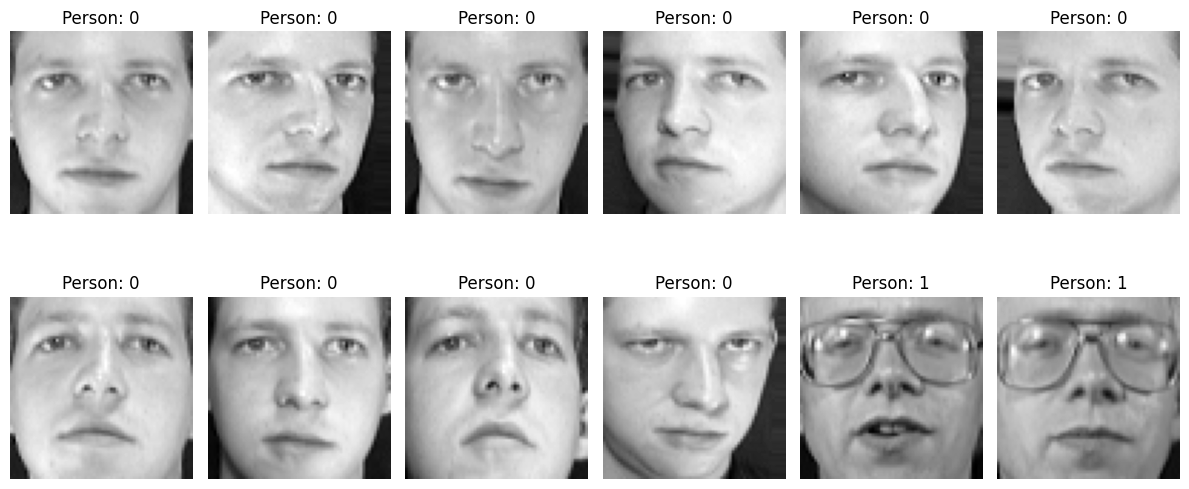

In [178]:
import matplotlib.pyplot as plt


num_samples = 12

plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, num_samples // 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Person: {target[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [179]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
import time
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score

In [180]:
models = {
    "CatBoost": CatBoostRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42)
}

In [181]:
results = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    start_time = time.time()
    predictions = model.predict(X_test)
    predict_time = time.time() - start_time

    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    explained_variance = explained_variance_score(y_test, predictions)

    results[name] = {
        "MAE": mae,
        "R^2": r2,
        "Explained Variance": explained_variance,
        "Training Time": train_time,
        "Prediction Time": predict_time
    }

for name, result in results.items():
    print(f"Название модели: {name}")
    print(f"MAE: {result['MAE']}")
    print(f"R^2: {result['R^2']}")
    print(f"Explained Variance: {result['Explained Variance']}")
    print(f"Время обучения: {result['Training Time']} seconds")
    print(f"Время на предсказание: {result['Prediction Time']} seconds")
    print("---------------------")

Learning rate set to 0.034197
0:	learn: 11.1554296	total: 87.3ms	remaining: 1m 27s
1:	learn: 11.0237663	total: 136ms	remaining: 1m 7s
2:	learn: 10.8945045	total: 184ms	remaining: 1m 1s
3:	learn: 10.8202903	total: 233ms	remaining: 57.9s
4:	learn: 10.6994209	total: 282ms	remaining: 56.1s
5:	learn: 10.5834543	total: 331ms	remaining: 54.8s
6:	learn: 10.4679881	total: 380ms	remaining: 53.8s
7:	learn: 10.3462737	total: 427ms	remaining: 52.9s
8:	learn: 10.2290078	total: 474ms	remaining: 52.1s
9:	learn: 10.1153048	total: 521ms	remaining: 51.6s
10:	learn: 10.0279283	total: 568ms	remaining: 51.1s
11:	learn: 9.9446018	total: 616ms	remaining: 50.7s
12:	learn: 9.8580568	total: 664ms	remaining: 50.4s
13:	learn: 9.7806754	total: 712ms	remaining: 50.1s
14:	learn: 9.6832615	total: 761ms	remaining: 50s
15:	learn: 9.5915845	total: 807ms	remaining: 49.6s
16:	learn: 9.4989628	total: 853ms	remaining: 49.3s
17:	learn: 9.4014354	total: 900ms	remaining: 49.1s
18:	learn: 9.2775032	total: 946ms	remaining: 48.8s


# Время обучения

In [182]:
import plotly.express as px

model_names = list(results.keys())
training_times = [result["Training Time"] for result in results.values()]
prediction_times = [result["Prediction Time"] for result in results.values()]

fig_training = px.bar(x=model_names, y=training_times, labels={"x": "Модель", "y": "Время обучения (сек)"}, 
                      title="Время обучения для каждой модели")
fig_training.update_traces(marker=dict(color=['red' if t == min(training_times) else 'blue' for t in training_times]))

fig_prediction = px.bar(x=model_names, y=prediction_times, labels={"x": "Модель", "y": "Время предсказания (сек)"}, 
                        title="Время предсказания для каждой модели")
fig_prediction.update_traces(marker=dict(color=['red' if t == min(prediction_times) else 'blue' for t in prediction_times]))

fig_training.show()
fig_prediction.show()



# Беседуя о точности

In [187]:
import plotly.express as px

accuracies = [result["R^2"] for result in results.values()]
model_names = list(results.keys())

best_r2_idx = accuracies.index(max(accuracies))

fig = px.bar(x=model_names, y=accuracies, labels={"x": "Модель", "y": "Точность"}, 
             title="Точность каждой модели R^2")

# Присваиваем красный цвет лучшей модели
fig.update_traces(marker_color=['red' if i == best_r2_idx else 'blue' for i in range(len(model_names))])

fig.show()



In [190]:
import plotly.express as px

accuracies = [result["MAE"] for result in results.values()]
model_names = list(results.keys())

best_mae_idx = accuracies.index(min(accuracies))

fig = px.bar(x=model_names, y=accuracies, labels={"x": "Модель", "y": "Точность"}, 
             title="Точность каждой модели MAE")

# Присваиваем красный цвет лучшей модели
fig.update_traces(marker_color=['red' if i == best_mae_idx else 'blue' for i in range(len(model_names))])

fig.show()


In [191]:
import plotly.express as px

accuracies = [result["Explained Variance"] for result in results.values()]
model_names = list(results.keys())

best_explained_variance_idx = accuracies.index(max(accuracies))

fig = px.bar(x=model_names, y=accuracies, labels={"x": "Модель", "y": "Точность"}, 
             title="Точность каждой модели Explained Variance")

# Присваиваем красный цвет лучшей модели
fig.update_traces(marker_color=['red' if i == best_explained_variance_idx else 'blue' for i in range(len(model_names))])

fig.show()
